In [1]:
def IntialiseEnv():
    nb_dir = os.path.split(os.getcwd())[0]
    if nb_dir not in sys.path:
        sys.path.append(nb_dir)

In [2]:
# Libraries
import os
import sys
IntialiseEnv()
import tensorflow as tf
import numpy as np
import math
import pickle
import cv2
import scipy
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [3]:
# Define paths
data_dir = r"Dataset"
train_path = os.path.join(data_dir, "Train")
test_path = os.path.join(data_dir, "Test")

# Check if the paths exist
print(f"Train directory exists: {os.path.exists(train_path)}")
print(f"Test directory exists: {os.path.exists(test_path)}")

# Define image dimensions for LeNet5 (traditionally 32x32)
IMG_HEIGHT = 32
IMG_WIDTH = 32
CHANNELS = 3

Train directory exists: True
Test directory exists: True


In [4]:
import tensorflow as tf
from tensorflow.keras import models, layers

def build_lenet5_model(input_shape=(32, 32, 3), num_classes=43):
    """
    Build LeNet5 model for traffic sign classification
    
    Parameters:
    - input_shape: shape of input images (height, width, channels)
    - num_classes: number of traffic sign classes
    
    Returns:
    - model: compiled LeNet5 model
    """
    model = models.Sequential([
        # Layer 1: Convolutional + ReLU + Pooling
        layers.Conv2D(6, kernel_size=(5, 5), padding='valid', activation='relu', input_shape=input_shape),
        layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
        
        # Layer 2: Convolutional + ReLU + Pooling
        layers.Conv2D(16, kernel_size=(5, 5), padding='valid', activation='relu'),
        layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
        
        # Flatten
        layers.Flatten(),
        
        # Layer 3: Fully Connected + ReLU
        layers.Dense(120, activation='relu'),
        
        # Layer 4: Fully Connected + ReLU
        layers.Dense(84, activation='relu'),
        
        # Output Layer
        layers.Dense(num_classes, activation='softmax')
    ])
    
    # Compile model
    model.compile(
        loss='categorical_crossentropy',
        optimizer='adam',
        metrics=['accuracy']
    )
    
    return model

In [5]:
def train_model(model, X_train, y_train, X_test, y_test, batch_size=32, epochs=20):
    """
    Train the LeNet5 model
    
    Parameters:
    - model: compiled LeNet5 model
    - X_train, y_train: training data
    - X_test, y_test: test data
    - batch_size: batch size for training
    - epochs: number of training epochs
    
    Returns:
    - history: training history
    - model: trained model
    """
    # Data augmentation to help with generalization
    datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        rotation_range=10,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.1,
        shear_range=0.1
    )
    
    # Convert labels to categorical if they aren't already
    if len(y_train.shape) == 1:
        y_train = tf.keras.utils.to_categorical(y_train)
        y_test = tf.keras.utils.to_categorical(y_test)
    
    # Early stopping to prevent overfitting
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    )
    
    # Train the model
    history = model.fit(
        datagen.flow(X_train, y_train, batch_size=batch_size),
        epochs=epochs,
        validation_data=(X_test, y_test),
        callbacks=[early_stopping]
    )
    
    # Evaluate on test data
    test_loss, test_acc = model.evaluate(X_test, y_test)
    print(f"Test accuracy: {test_acc:.4f}")
    
    return history, model

In [6]:
def load_data_from_folders(train_path, test_path):
    """
    Load data from folder structure if pickle files don't exist
    """
    train_data = []
    train_labels = []
    test_data = []
    test_labels = []
    
    # Load training data
    print("Loading training data from folders...")
    for class_id in range(43):  # 43 classes in GTSRB dataset
        class_path = os.path.join(train_path, str(class_id))
        if not os.path.exists(class_path):
            continue
            
        for image_file in os.listdir(class_path):
            if not image_file.endswith('.png') and not image_file.endswith('.jpg') and not image_file.endswith('.ppm'):
                continue
                
            img_path = os.path.join(class_path, image_file)
            img = cv2.imread(img_path)
            if img is None:
                continue
                
            img = cv2.resize(img, (IMG_HEIGHT, IMG_WIDTH))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
            train_data.append(img)
            train_labels.append(class_id)
    
    # Load test data
    print("Loading test data from folders...")
    for class_id in range(43):
        class_path = os.path.join(test_path, str(class_id))
        if not os.path.exists(class_path):
            continue
            
        for image_file in os.listdir(class_path):
            if not image_file.endswith('.png') and not image_file.endswith('.jpg') and not image_file.endswith('.ppm'):
                continue
                
            img_path = os.path.join(class_path, image_file)
            img = cv2.imread(img_path)
            if img is None:
                continue
                
            img = cv2.resize(img, (IMG_HEIGHT, IMG_WIDTH))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
            test_data.append(img)
            test_labels.append(class_id)
    
    # Convert to numpy arrays
    train_data = np.array(train_data)
    train_labels = np.array(train_labels)
    test_data = np.array(test_data)
    test_labels = np.array(test_labels)
    
    print(f"Training data loaded: {train_data.shape}, {train_labels.shape}")
    print(f"Test data loaded: {test_data.shape}, {test_labels.shape}")
    
    return train_data, train_labels, test_data, test_labels

In [7]:
def load_data_from_pickle():
    """
    Load data from pickle files if they exist
    """
    train_file = os.path.join(data_dir, "Processed_DataSet", "GermanTrainDataSet.pkl")
    test_file = os.path.join(data_dir, "Processed_DataSet", "GermanTestDataSet.pkl")
    
    train_data, train_labels = None, None
    test_data, test_labels = None, None
    
    if os.path.exists(train_file):
        print("Loading training data from pickle file...")
        with open(train_file, 'rb') as f:
            train_data, train_labels = pickle.load(f)
        print(f"Training data loaded: {train_data.shape}, {train_labels.shape}")
    
    if os.path.exists(test_file):
        print("Loading test data from pickle file...")
        with open(test_file, 'rb') as f:
            test_data, test_labels = pickle.load(f)
        print(f"Test data loaded: {test_data.shape}, {test_labels.shape}")
    
    return train_data, train_labels, test_data, test_labels

In [8]:
# Load data
train_data, train_labels, test_data, test_labels = load_data_from_pickle()

# If pickle files don't exist, load from folders
if train_data is None or test_data is None:
    train_data, train_labels, test_data, test_labels = load_data_from_folders(train_path, test_path)

# Check data shapes and types
print(f"Training data shape: {train_data.shape}")
print(f"Training labels shape: {train_labels.shape}")
print(f"Test data shape: {test_data.shape}")
print(f"Test labels shape: {test_labels.shape}")

# Check unique classes
num_classes = len(np.unique(train_labels))
print(f"Number of unique classes: {num_classes}")


Loading training data from folders...
Loading test data from folders...
Training data loaded: (39705, 32, 32, 3), (39705,)
Test data loaded: (0,), (0,)
Training data shape: (39705, 32, 32, 3)
Training labels shape: (39705,)
Test data shape: (0,)
Test labels shape: (0,)
Number of unique classes: 43


In [9]:
# Preprocess data
def preprocess_data(X_train, X_test, y_train, y_test):
    # Resize to target dimensions if necessary
    if X_train.shape[1:3] != (IMG_HEIGHT, IMG_WIDTH):
        X_train_resized = []
        for img in X_train:
            X_train_resized.append(cv2.resize(img, (IMG_HEIGHT, IMG_WIDTH)))
        X_train = np.array(X_train_resized)
        
        X_test_resized = []
        for img in X_test:
            X_test_resized.append(cv2.resize(img, (IMG_HEIGHT, IMG_WIDTH)))
        X_test = np.array(X_test_resized)
    
    # Normalize pixel values to [0,1]
    X_train = X_train.astype('float32') / 255.0
    X_test = X_test.astype('float32') / 255.0
    
    # Convert labels to categorical
    y_train_cat = to_categorical(y_train, num_classes=num_classes)
    y_test_cat = to_categorical(y_test, num_classes=num_classes)
    
    return X_train, X_test, y_train_cat, y_test_cat

In [10]:
# Apply preprocessing
X_train, X_test, y_train, y_test = preprocess_data(train_data, test_data, train_labels, test_labels)

# Verify shapes after preprocessing
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (39705, 32, 32, 3)
y_train shape: (39705, 43)
X_test shape: (0,)
y_test shape: (0, 43)


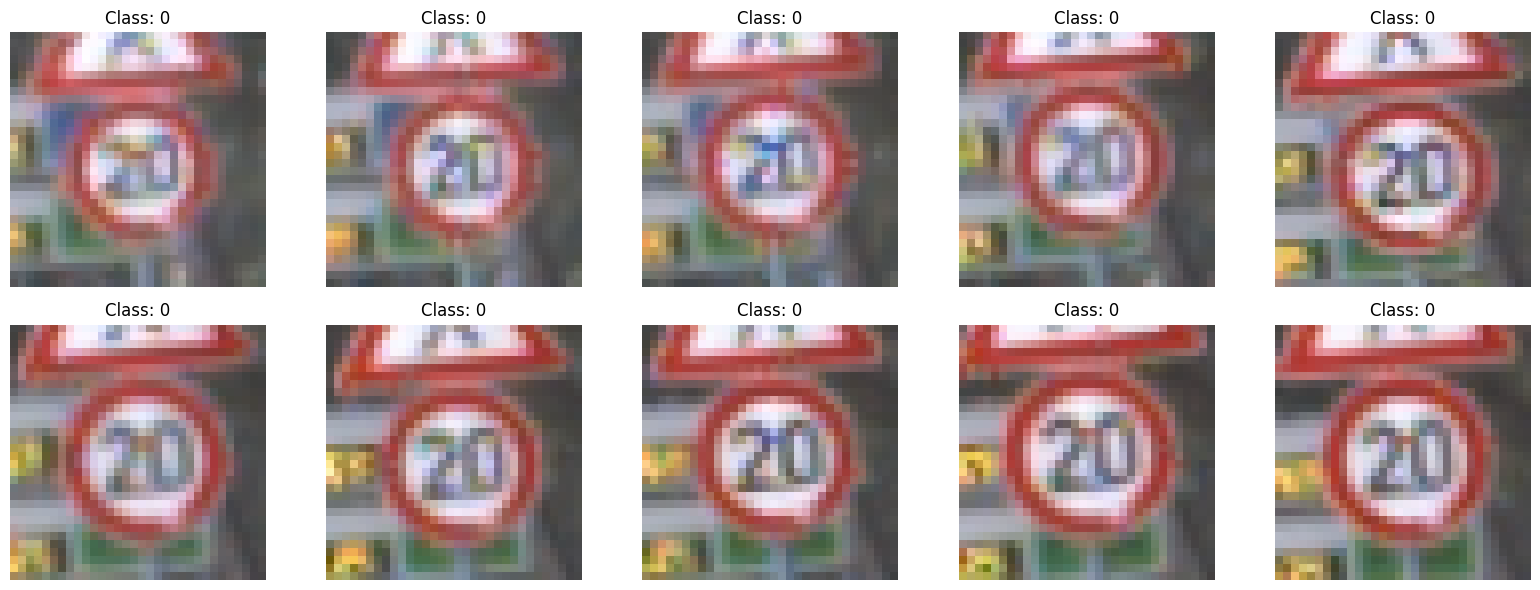

In [11]:
# Display some sample images
plt.figure(figsize=(16, 6))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(X_train[i])
    plt.title(f"Class: {np.argmax(y_train[i])}")
    plt.axis('off')
plt.tight_layout()
plt.show()

In [12]:
# Build LeNet5 model
def build_lenet5_model(input_shape=(32, 32, 3), num_classes=43):
    """Build LeNet5 architecture for traffic sign recognition"""
    model = tf.keras.models.Sequential([
        # Layer 1: Convolutional + ReLU + Pooling
        tf.keras.layers.Conv2D(6, kernel_size=(5, 5), padding='same', 
                              activation='relu', input_shape=input_shape),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
        
        # Layer 2: Convolutional + ReLU + Pooling
        tf.keras.layers.Conv2D(16, kernel_size=(5, 5), padding='valid', 
                              activation='relu'),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
        
        # Layer 3: Convolutional + ReLU (additional to original LeNet5 to handle complexity)
        tf.keras.layers.Conv2D(32, kernel_size=(3, 3), padding='valid', 
                             activation='relu'),
        
        # Flatten
        tf.keras.layers.Flatten(),
        
        # Layer 4: Fully Connected + ReLU
        tf.keras.layers.Dense(120, activation='relu'),
        tf.keras.layers.Dropout(0.5),  # Add dropout to prevent overfitting
        
        # Layer 5: Fully Connected + ReLU
        tf.keras.layers.Dense(84, activation='relu'),
        tf.keras.layers.Dropout(0.5),  # Add dropout to prevent overfitting
        
        # Output Layer
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])
    
    # Compile model
    model.compile(
        loss='categorical_crossentropy',
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        metrics=['accuracy']
    )
    
    return model

In [13]:
# Create LeNet5 model
model = build_lenet5_model(input_shape=(IMG_HEIGHT, IMG_WIDTH, CHANNELS), num_classes=num_classes)

# Display model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 6)         456       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 6)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 12, 12, 16)        2416      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 16)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 32)          4640      
                                                                 
 flatten (Flatten)           (None, 512)               0

In [14]:
# Create save directory if it doesn't exist
save_dir = r".\saved_models"
os.makedirs(save_dir, exist_ok=True)
model_path = os.path.join(save_dir, 'lenet5_traffic_sign_model.h5')

# Setup data augmentation for better generalization
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    shear_range=0.1,
    horizontal_flip=False  # No horizontal flip for traffic signs as it changes meaning
)

# Setup callbacks
checkpoint = ModelCheckpoint(
    'lenet5_traffic_sign_model.h5', 
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)



In [15]:
# Train model
batch_size = 64
epochs = 30

history = model.fit(
    datagen.flow(X_train, y_train, batch_size=batch_size),
    steps_per_epoch=len(X_train) // batch_size,
    epochs=epochs,
    # validation_data=(X_test, y_test),
    callbacks=[checkpoint, early_stopping]
)

# After training, save the model regardless of whether the callback saved it
model.save(model_path)
print(f"Model saved to {model_path}")

# Load best model
# Use the model in memory for evaluation (no need to load)
best_model = model

Epoch 1/30
620/620 [==============================] - 13s 19ms/step - loss: 2.8169 - accuracy: 0.2134
Epoch 2/30
620/620 [==============================] - 12s 20ms/step - loss: 1.8428 - accuracy: 0.4071
Epoch 3/30
620/620 [==============================] - 12s 19ms/step - loss: 1.4946 - accuracy: 0.5030
Epoch 4/30
620/620 [==============================] - 12s 19ms/step - loss: 1.2280 - accuracy: 0.5906
Epoch 5/30
620/620 [==============================] - 12s 19ms/step - loss: 1.0443 - accuracy: 0.6505
Epoch 6/30
620/620 [==============================] - 12s 20ms/step - loss: 0.9091 - accuracy: 0.6993
Epoch 7/30
620/620 [==============================] - 12s 20ms/step - loss: 0.7933 - accuracy: 0.7367
Epoch 8/30
620/620 [==============================] - 12s 19ms/step - loss: 0.7097 - accuracy: 0.7653
Epoch 9/30
620/620 [==============================] - 12s 19ms/step - loss: 0.6498 - accuracy: 0.7881
Epoch 10/30
620/620 [==============================] - 12s 19ms/step - loss: 0.606

In [16]:
# Check what keys are available in history.history
print("Available keys in history.history:", list(history.history.keys()))

Available keys in history.history: ['loss', 'accuracy']


Available keys in history.history: ['loss', 'accuracy']


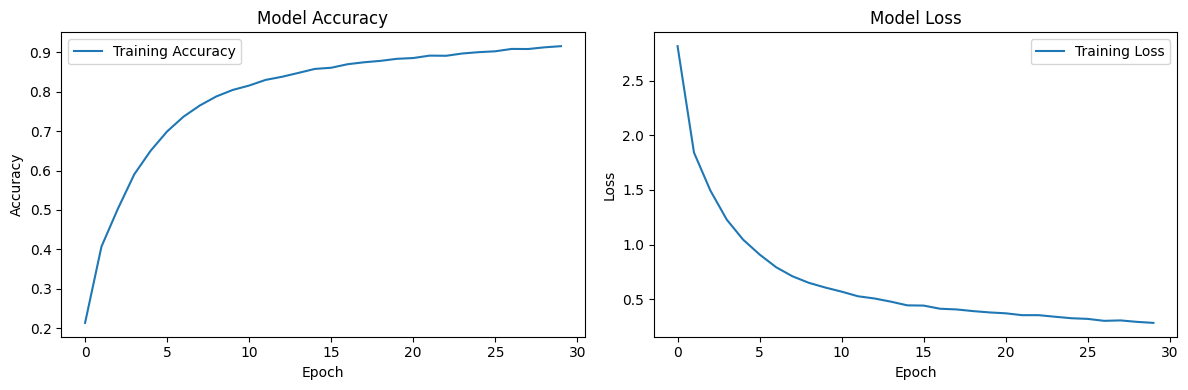

In [17]:
# Plot training history
plt.figure(figsize=(12, 4))

# Get available keys
available_keys = list(history.history.keys())
print("Available keys in history.history:", available_keys)

# Plot accuracy if available
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss if available
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [18]:
import pandas as pd
import cv2
import os
import numpy as np
from pathlib import Path

# Load the test CSV
test_df = pd.read_csv('Dataset\Test.csv')

# Base directory where test images are stored (adjust this to your actual directory)
base_dir = Path('Dataset')  # Adjust this to match your actual directory
# Function to load and preprocess an image - with correct size
def load_image(row, target_size=(32, 32)):  # Changed from 224x224 to 32x32
    # Construct full path to image
    img_path = base_dir / row['Path']
    
    if not os.path.exists(img_path):
        print(f"Warning: Image not found: {img_path}")
        return None
    
    # Read image
    image = cv2.imread(str(img_path))
    if image is None:
        print(f"Warning: Could not read image: {img_path}")
        return None
        
    # Convert BGR to RGB
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Extract ROI if needed
    if all(x in row for x in ['Roi.X1', 'Roi.Y1', 'Roi.X2', 'Roi.Y2']):
        x1, y1, x2, y2 = int(row['Roi.X1']), int(row['Roi.Y1']), int(row['Roi.X2']), int(row['Roi.Y2'])
        image = image[y1:y2, x1:x2]
    
    # Resize image to target size
    image = cv2.resize(image, target_size)
    
    # Normalize pixel values
    image = image / 255.0
    
    return image

# Prepare test data - updated batch_size
def prepare_test_data(batch_size=32):
    images = []
    labels = []
    filenames = []
    
    for _, row in test_df.iterrows():
        img = load_image(row, target_size=(32, 32))  # Ensure this matches model input size
        if img is not None:
            images.append(img)
            labels.append(row['ClassId'])
            filenames.append(row['Path'])
            
            if len(images) == batch_size:
                yield np.array(images), np.array(labels), filenames
                images, labels, filenames = [], [], []
    
    # Return any remaining samples
    if images:
        yield np.array(images), np.array(labels), filenames

# Example test function - updated with better error handling
def test_model(model):
    total = 0
    correct = 0
    class_correct = {}  # Track correct predictions per class
    class_total = {}    # Track total instances per class
    
    for test_images, test_labels, filenames in prepare_test_data():
        # Get predictions from model
        try:
            predictions = model.predict(test_images, verbose=0)
            pred_labels = np.argmax(predictions, axis=1)
            
            # Update statistics
            for i, (pred, actual, filename) in enumerate(zip(pred_labels, test_labels, filenames)):
                total += 1
                if pred == actual:
                    correct += 1
                    
                # Update per-class statistics
                if actual not in class_total:
                    class_total[actual] = 0
                    class_correct[actual] = 0
                    
                class_total[actual] += 1
                if pred == actual:
                    class_correct[actual] += 1
                    
                # Optional: Print details about incorrect predictions
                if pred != actual:
                    print(f"Misclassified {filename}: Predicted {pred}, Actual {actual}")
        except Exception as e:
            print(f"Error processing batch: {e}")
            # Optionally print the shape
            print(f"Shape of test_images: {test_images.shape}")
    
    # Calculate overall accuracy
    accuracy = correct / total if total > 0 else 0
    print(f"\nOverall Test accuracy: {accuracy:.4f} ({correct}/{total})")
    
    # Print per-class accuracy
    print("\nPer-class accuracy:")
    for class_id in sorted(class_total.keys()):
        class_acc = class_correct[class_id] / class_total[class_id] if class_total[class_id] > 0 else 0
        print(f"Class {class_id}: {class_acc:.4f} ({class_correct[class_id]}/{class_total[class_id]})")
    
    return accuracy


# To use this, you would load your model and call:
# model = load_your_model()
# test_model(model)

In [19]:
test_model(best_model)


Misclassified Test/00030.png: Predicted 2, Actual 5
Misclassified Test/00034.png: Predicted 1, Actual 2
Misclassified Test/00049.png: Predicted 4, Actual 8
Misclassified Test/00050.png: Predicted 40, Actual 25
Misclassified Test/00056.png: Predicted 2, Actual 5
Misclassified Test/00064.png: Predicted 4, Actual 15
Misclassified Test/00066.png: Predicted 18, Actual 26
Misclassified Test/00092.png: Predicted 6, Actual 2
Misclassified Test/00117.png: Predicted 28, Actual 29
Misclassified Test/00121.png: Predicted 1, Actual 7
Misclassified Test/00124.png: Predicted 6, Actual 2
Misclassified Test/00129.png: Predicted 42, Actual 6
Misclassified Test/00138.png: Predicted 1, Actual 2
Misclassified Test/00140.png: Predicted 9, Actual 41
Misclassified Test/00142.png: Predicted 1, Actual 6
Misclassified Test/00145.png: Predicted 24, Actual 25
Misclassified Test/00156.png: Predicted 1, Actual 6
Misclassified Test/00158.png: Predicted 1, Actual 7
Misclassified Test/00163.png: Predicted 24, Actual 25

0.8615993665874901

In [20]:
# Save model for future use
best_model.save('LeNETModel.h5')
print("Model saved as 'LeNETModel.h5'")

# Define class labels for future reference
classes = {
    0:'Speed limit (20km/h)',
    1:'Speed limit (30km/h)',
    2:'Speed limit (50km/h)',
    3:'Speed limit (60km/h)',
    4:'Speed limit (70km/h)',
    5:'Speed limit (80km/h)',
    6:'Speed limit (90km/h)',
    7:'Speed limit (100km/h)',
    8:'Speed limit (120km/h)',
    9:'No passing',
    10:'No passing veh over 3.5 tons',
    11:'Right-of-way at intersection',
    12:'Priority road',
    13:'Yield',
    14:'Stop',
    15:'No vehicles',
    16:'Veh > 3.5 tons prohibited',
    17:'No entry',
    18:'General caution',
    19:'Dangerous curve left',
    20:'Dangerous curve right',
    21:'Double curve',
    22:'Bumpy road',
    23:'Slippery road',
    24:'Road narrows on the right',
    25:'Road work',
    26:'Traffic signals',
    27:'Pedestrians',
    28:'Children crossing',
    29:'Bicycles crossing',
    30:'Beware of ice/snow',
    31:'Wild animals crossing',
    32:'End speed + passing limits',
    33:'Turn right ahead',
    34:'Turn left ahead',
    35:'Ahead only',
    36:'Go straight or right',
    37:'Go straight or left',
    38:'Keep right',
    39:'Keep left',
    40:'Roundabout mandatory',
    41:'End of no passing',
    42:'End no passing veh > 3.5 tons'
}

# Save class labels
with open('classes.pkl', 'wb') as f:
    pickle.dump(classes, f)
print("Class labels saved as 'classes.pkl'")

Model saved as 'LeNETModel.h5'
Class labels saved as 'classes.pkl'


In [7]:
import sys
import cv2
import numpy as np
import tensorflow as tf
import time
import os
from PIL import Image
import argparse

class TrafficSignDetector:
    def __init__(self, model_path, confidence_threshold=0.7, min_detections=3, time_window=0.8, process_every_n_frames=2):
        """
        Initialize traffic sign detector with temporal filtering
        
        Args:
            model_path: Path to trained classification model
            confidence_threshold: Minimum confidence to consider a detection valid
            min_detections: Minimum number of detections needed within time window to report a sign
            time_window: Time window in seconds for temporal filtering
            process_every_n_frames: Process only every Nth frame for speed
        """
        # Load trained model
        print(f"Loading model from {model_path}...")
        self.model = tf.keras.models.load_model(model_path)
        print("Model loaded successfully")
        
        # Sign detector: Using color and shape detection for speed
        self.detector_initialized = False
        
        # Detection parameters
        self.confidence_threshold = confidence_threshold
        self.process_every_n_frames = process_every_n_frames
        self.frame_counter = 0
        
        # Define class names
        self.classes = { 
            0:'Speed limit (20km/h)', 1:'Speed limit (30km/h)', 
            2:'Speed limit (50km/h)', 3:'Speed limit (60km/h)', 
            4:'Speed limit (70km/h)', 5:'Speed limit (80km/h)', 
            6:'Speed limit (90km/h)', 7:'Speed limit (100km/h)', 
            8:'Speed limit (120km/h)', 9:'No passing', 
            10:'No passing veh over 3.5 tons', 11:'Right-of-way at intersection', 
            12:'Priority road', 13:'Yield', 14:'Stop', 
            15:'No vehicles', 16:'Veh > 3.5 tons prohibited', 
            17:'No entry', 18:'General caution', 
            19:'Dangerous curve left', 20:'Dangerous curve right', 
            21:'Double curve', 22:'Bumpy road', 
            23:'Slippery road', 24:'Road narrows on the right', 
            25:'Road work', 26:'Traffic signals', 
            27:'Pedestrians', 28:'Children crossing', 
            29:'Bicycles crossing', 30:'Beware of ice/snow',
            31:'Wild animals crossing', 32:'End speed + passing limits', 
            33:'Turn right ahead', 34:'Turn left ahead', 
            35:'Ahead only', 36:'Go straight or right', 
            37:'Go straight or left', 38:'Keep right', 
            39:'Keep left', 40:'Roundabout mandatory', 
            41:'End of no passing', 42:'End no passing veh > 3.5 tons' 
        }
        
        # Temporal filtering for detection stability
        self.detection_history = {}  # {class_id: [(timestamp, confidence, box), ...]}
        self.min_detections = min_detections
        self.time_window = time_window
        self.stable_detections = {}  # Currently visible stable detections
        
        # Region of interest parameters - focus on where signs typically appear
        self.use_roi = True
        self.roi_x_start = 0
        self.roi_y_start = 0
        self.roi_width = 1.0  # Will be calculated as fraction of frame width
        self.roi_height = 0.6  # Will be calculated as fraction of frame height
        
    def _initialize_detector(self, frame):
        """Initialize detector parameters based on first frame"""
        h, w = frame.shape[:2]
        
        # Calculate ROI dimensions
        self.roi_x_start = int(w * 0.1)  # Start 10% from left
        self.roi_width = int(w * 0.8)    # Use middle 80% of width
        self.roi_y_start = 0             # Start from top
        self.roi_height = int(h * 0.6)   # Use top 60% of height
        
        self.detector_initialized = True
        
    def detect_potential_signs(self, frame):
        """Detect potential traffic sign regions using color and shape detection"""
        # Work on ROI if enabled
        if self.use_roi:
            x_end = self.roi_x_start + self.roi_width
            y_end = self.roi_y_start + self.roi_height
            roi = frame[self.roi_y_start:y_end, self.roi_x_start:x_end]
        else:
            roi = frame
            
        # Convert to HSV for better color detection
        hsv = cv2.cvtColor(roi, cv2.COLOR_BGR2HSV)
        
        # Detect red signs
        lower_red1 = np.array([0, 100, 100])
        upper_red1 = np.array([10, 255, 255])
        lower_red2 = np.array([160, 100, 100])
        upper_red2 = np.array([180, 255, 255])
        
        red_mask1 = cv2.inRange(hsv, lower_red1, upper_red1)
        red_mask2 = cv2.inRange(hsv, lower_red2, upper_red2)
        red_mask = cv2.bitwise_or(red_mask1, red_mask2)
        
        # Detect blue signs
        lower_blue = np.array([100, 80, 80])
        upper_blue = np.array([130, 255, 255])
        blue_mask = cv2.inRange(hsv, lower_blue, upper_blue)
        
        # Combine masks
        mask = cv2.bitwise_or(red_mask, blue_mask)
        
        # Find contours
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        # Filter contours by size and shape
        potential_signs = []
        min_area = 400  # Minimum area to consider
        
        for contour in contours:
            area = cv2.contourArea(contour)
            
            if area < min_area:
                continue
                
            # Get bounding box
            x, y, w, h = cv2.boundingRect(contour)
            
            # Filter by aspect ratio (signs are roughly square)
            aspect_ratio = float(w) / h
            if 0.7 <= aspect_ratio <= 1.3:  # Close to square
                # Adjust coordinates to full frame if using ROI
                if self.use_roi:
                    x += self.roi_x_start
                    y += self.roi_y_start
                    
                potential_signs.append((x, y, w, h))
                
        return potential_signs
        
    def classify_sign(self, frame, x, y, w, h):
        """Classify a detected region using the CNN model"""
        # Extract region
        sign_roi = frame[y:y+h, x:x+w]
        
        # Prepare for model
        try:
            # Convert to RGB (our model expects RGB)
            rgb_roi = cv2.cvtColor(sign_roi, cv2.COLOR_BGR2RGB)
            
            # Convert to PIL and resize
            pil_img = Image.fromarray(rgb_roi)
            resized_img = pil_img.resize((32, 32))  # Model input size
            
            # Normalize and expand dimensions for batch
            img_array = np.array(resized_img) / 255.0
            img_array = np.expand_dims(img_array, axis=0)
            
            # Make prediction
            predictions = self.model.predict(img_array, verbose=0)
            class_id = np.argmax(predictions[0])
            confidence = predictions[0][class_id]
            
            return class_id, confidence
            
        except Exception as e:
            print(f"Error classifying sign: {e}")
            return None, 0.0
            
    def add_detection(self, class_id, confidence, box, timestamp):
        """Add a new sign detection to history for temporal filtering"""
        if class_id not in self.detection_history:
            self.detection_history[class_id] = []
            
        # Add current detection
        self.detection_history[class_id].append((timestamp, confidence, box))
        
        # Remove old detections
        self.detection_history[class_id] = [
            d for d in self.detection_history[class_id]
            if timestamp - d[0] <= self.time_window
        ]
        
    def get_stable_detections(self, current_time):
        """Get signs that have been consistently detected"""
        self.stable_detections = {}
        
        for class_id, detections in self.detection_history.items():
            # Only consider recent detections
            recent = [d for d in detections if current_time - d[0] <= self.time_window]
            
            if len(recent) >= self.min_detections:
                # Calculate average confidence and position
                avg_conf = sum(conf for _, conf, _ in recent) / len(recent)
                
                # Use the most recent box position
                self.stable_detections[class_id] = (avg_conf, recent[-1][2])
                
        return self.stable_detections
        
    def process_frame(self, frame):
        """Process a single frame to detect traffic signs"""
        # Initialize detector parameters if not done yet
        if not self.detector_initialized:
            self._initialize_detector(frame)
            
        # Skip frames for performance
        self.frame_counter += 1
        if self.frame_counter % self.process_every_n_frames != 0:
            # Draw existing stable detections on skipped frames
            output_frame = frame.copy()
            self._draw_stable_detections(output_frame)
            return output_frame
            
        current_time = time.time()
        output_frame = frame.copy()
        
        # 1. Find potential sign regions
        potential_signs = self.detect_potential_signs(frame)
        
        # 2. Classify each potential sign
        for x, y, w, h in potential_signs:
            class_id, confidence = self.classify_sign(frame, x, y, w, h)
            
            # Only consider high confidence detections
            if confidence >= self.confidence_threshold:
                self.add_detection(class_id, confidence, (x, y, w, h), current_time)
        
        # 3. Update and draw stable detections
        self.get_stable_detections(current_time)
        self._draw_stable_detections(output_frame)
        
        return output_frame
    
    def _draw_stable_detections(self, frame):
        """Draw bounding boxes and labels for stable detections"""
        for class_id, (confidence, (x, y, w, h)) in self.stable_detections.items():
            # Draw rectangle
            cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)
            
            # Get class name
            label = self.classes.get(class_id, "Unknown")
            
            # Draw label background
            label_text = f"{label}: {confidence:.2f}"
            font = cv2.FONT_HERSHEY_SIMPLEX
            font_scale = 0.5
            thickness = 2
            size, _ = cv2.getTextSize(label_text, font, font_scale, thickness)
            
            cv2.rectangle(frame, (x, y-size[1]-5), (x+size[0], y), (0, 0, 0), -1)
            cv2.putText(frame, label_text, (x, y-5), font, font_scale, (255, 255, 255), thickness)
            
        # Optional: Draw ROI if enabled
        if self.use_roi:
            x_end = self.roi_x_start + self.roi_width
            y_end = self.roi_y_start + self.roi_height
            cv2.rectangle(frame, (self.roi_x_start, self.roi_y_start), (x_end, y_end), (255, 0, 0), 2)

def main():
    # Check if running in a Jupyter Notebook
    if 'ipykernel' in sys.modules:
        # Set default arguments for Jupyter Notebook
        video_source = r"./CarlaVideos/traffic signs test.mp4"
        model_path = r"./LeNETModel.h5"
        confidence_threshold = 0.9
        skip_frames = 2
        min_detections = 4
    else:
        # Parse arguments
        parser = argparse.ArgumentParser(description='Traffic Sign Detection and Classification')
        parser.add_argument('--video', type=str, default=0, help='Path to video file or camera index')
        parser.add_argument('--model', type=str, default='traffic_sign_model.h5', help='Path to trained model')
        parser.add_argument('--confidence', type=float, default=0.7, help='Confidence threshold')
        parser.add_argument('--skip-frames', type=int, default=2, help='Process every Nth frame')
        parser.add_argument('--min-detections', type=int, default=3, help='Minimum detections to consider stable')
        args = parser.parse_args()
        
        video_source = args.video
        model_path = args.model
        confidence_threshold = args.confidence
        skip_frames = args.skip_frames
        min_detections = args.min_detections
    
    # Initialize detector
    detector = TrafficSignDetector(
        model_path=model_path,
        confidence_threshold=confidence_threshold,
        min_detections=min_detections,
        process_every_n_frames=skip_frames
    )
    
    # Open video source
    try:
        cap = cv2.VideoCapture(video_source)
        
        if not cap.isOpened():
            raise Exception(f"Cannot open video source {video_source}")
        
        # Get the video's FPS
        fps = cap.get(cv2.CAP_PROP_FPS)
        frame_delay = int(1000 / fps)  # Delay in milliseconds
        
        fps_values = []  # Store last 10 FPS values for smoothing
        
        while True:
            ret, frame = cap.read()
            if not ret:
                print("End of video or error reading frame")
                break
                
            # Process frame
            start_time = time.time()
            processed_frame = detector.process_frame(frame)
            process_time = time.time() - start_time
            
            # Calculate FPS with smoothing
            if process_time > 0:  # Avoid division by zero
                current_fps = 1.0 / process_time
                fps_values.append(current_fps)
                # Keep only last 10 values
                if len(fps_values) > 10:
                    fps_values.pop(0)
                # Average FPS    
                avg_fps = sum(fps_values) / len(fps_values)
                cv2.putText(processed_frame, f"FPS: {avg_fps:.1f}", (10, 30), 
                            cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
            
            # Display result
            cv2.imshow("Traffic Sign Detection", processed_frame)
            
            # Introduce delay to match the video's FPS
            if cv2.waitKey(frame_delay) & 0xFF == 27:
                break
                
    except Exception as e:
        print(f"Error: {e}")
        import traceback
        traceback.print_exc()
        
    finally:
        if 'cap' in locals():
            cap.release()
        cv2.destroyAllWindows()

if __name__ == "__main__":
    main()

Loading model from ./LeNETModel.h5...
Model loaded successfully
End of video or error reading frame
